<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/Copy_of_LSTM_Blizzard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import pandas as pd
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [ ]:
df = pd.read_csv('data1.csv',parse_dates=['date'])
df.set_index('date', inplace=True)
feature_names = ['ap','ws']
target = 'blizzard'
features = df[feature_names]
labels = df[target]
df.head()




,tempr,ap,ws,rh,blizzard,ws_filtered,ap_filtered
date,,,,,,,
2016-01-01 00:00:00,1.16,980.83,8.27,67.60,0,10.596980,980.080081
2016-01-01 01:00:00,1.35,980.95,10.91,65.30,0,10.596837,980.078782
2016-01-01 02:00:00,1.53,981.07,8.59,64.70,0,10.596693,980.077482
2016-01-01 03:00:00,1.43,981.37,8.18,66.10,0,10.596549,980.076183
2016-01-01 04:00:00,1.24,981.66,9.19,73.86,0,10.596405,980.074884


In [ ]:
class MovingAverageEarlyStopping:
  def __init__(self,patience=5,window_size=3,min_delta=0.00001):

    self.patience = patience                # How long to wait after last good moving avg improvement
    self.window_size = window_size          # How many epochs to average over
    self.min_delta = min_delta              # Minimum change to be considered improvement
    self.history = []                       # Store past validation metrics
    self.best_moving_avg = None             # Best moving avg value seen
    self.counter = 0                        # Counter for patience


  def step(self,current_value):
    self.history.append(current_value)

    if len(self.history)<self.window_size:
      return False #Too early to judge - window not even complete

    moving_avg = np.mean(self.history[-self.window_size:])#Calculate the moving average of the last window_size validation scores

    if (self.best_moving_avg is None) or (self.best_moving_avg<moving_avg):
      self.best_moving_avg = moving_avg
      self.counter = 0
    else:
      self.counter+=1

    if self.counter>=self.patience:
      return True
    return False#Else, continues training.







In [ ]:
#predicting whether there will be a blizzard in the next hour.
def create_sequences(data,labels,lookback):
  X = []
  y = []
  for i in range(len(data)-lookback):
    seq = data[i:(i+lookback)].values
    lab = labels[i+lookback]
    X.append(seq)
    y.append(lab)
  return np.array(X),np.array(y)


In [ ]:
train_len = 0.7
val_len = 0.15
test_len = 0.15


#Splitting dataset into training, validation and testing datasets.
#X_train = features[:int(train_len*len(features))]
#y_train = labels[:int(train_len*len(labels))]
#X_val = features[int(train_len*len(features)):int((train_len+val_len)*len(features))]
#y_val = labels[int(train_len*len(labels)):int((train_len+val_len)*len(labels))]
#X_test = features[int((train_len+val_len)*len(features)):]
#y_test = labels[int((train_len+val_len)*len(labels)):]

X , y = create_sequences(features,labels,5)
X.shape




/tmp/ipython-input-4-3336903119.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lab = labels[i+lookback]


(44683, 5, 2)

In [ ]:

#train_test_split not used to ensure that we have three said,
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

np.random.seed(42)
num_samples = X.shape[0]
indices = np.arange(num_samples)
np.random.shuffle(indices)


train_end = train_len*num_samples
val_end = val_len*num_samples + train_end
train_indices = X[:int(train_end)]
val_indices = X[int(train_end):int(val_end)]
test_indices = X[int(val_end):]

X_train = X[:int(train_end)]
y_train = y[:int(train_end)]
X_val = X[int(train_end):int(val_end)]
y_val = y[int(train_end):int(val_end)]
X_test =  X[int(val_end):]
y_test = y[int(val_end):]



num_train, seq_len_train, num_features_train = X_train.shape
X_train_reshaped = X_train.reshape(-1,num_features_train)

num_test,seq_len_test, num_features_test = X_test.shape
X_test_reshaped = X_test.reshape(-1,num_features_test)

num_val, seq_len_val, num_features_val = X_val.shape
X_val_reshaped = X_val.reshape(-1,num_features_val)



#X_train.shape,X_val.shape,X_test.shape
#X_train.shape,X_train_reshaped.shape,X_test.shape

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train_reshaped)
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_train, seq_len_train, num_features_train)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(num_test,seq_len_test, num_features_test)
X_val_scaled =scaler.transform(X_val_reshaped).reshape(num_val, seq_len_val, num_features_val)


train_set = TensorDataset(torch.tensor(X_train_scaled,dtype=torch.float32),torch.tensor(y_train,dtype=torch.float32))
test_set = TensorDataset(torch.tensor(X_test_scaled,dtype=torch.float32),torch.tensor(y_test,dtype=torch.float32))
val_set = TensorDataset(torch.tensor(X_val_scaled,dtype=torch.float32),torch.tensor(y_val,dtype=torch.float32))
train_loader = DataLoader(train_set,batch_size = 32,shuffle = True,drop_last = True)
test_loader = DataLoader(test_set,batch_size = 32,shuffle = False,drop_last = True)
val_loader = DataLoader(val_set,batch_size=32,shuffle=True,drop_last = True)

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size =2,hidden_size = 64,num_layers = 2):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size = 2, hidden_size =64, num_layers = 2,batch_first=True)
    self.fc = nn.Linear(in_features = 64, out_features = 1)



  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device = x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device = x.device)
    out,_ = self.lstm(x,(h0,c0))
    out = self.fc(out[:,-1,:])
    return out



In [ ]:
epochs = 100
batch_size = 32
model = LSTM()
num_pos = y_train.sum()
num_neg = len(y_train) - num_pos
pos_wt = torch.tensor(num_neg / num_pos)

criterion = nn.BCEWithLogitsLoss(pos_wt)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.005)
patience = 5
best_f1  = 0
patience_Counter = 0

best_val_loss = np.inf




In [ ]:
losses = []
early_stopper = MovingAverageEarlyStopping(patience=5, window_size=3, min_delta=0.000001)#Initialising the earyMovingAveragaeStopper


for epoch in range(epochs):
  model.train()
  train_loss = 0
  for X_train,y_train in train_loader:
    optimizer.zero_grad()
    y_pred =  model(X_train).squeeze()
    loss = criterion(y_pred,y_train)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()

  model.eval()
  val_preds = [] #List of all batches predicted values
  val_labels = [] #List of all batches actual values
  val_loss = 0
  with torch.no_grad():
    for X_test,y_test in val_loader:
      y_test_out = model(X_test).squeeze()
      y_test_pred = torch.sigmoid(y_test_out)
      y_test_pred = (y_test_pred>0.5).float()
      val_preds.extend(y_test_pred.cpu().numpy()) #NUMPY WORKS ONLY ON CPU - NOT ON GPU; .numpy() converts pytorch tensor to a numpy array
      val_labels.extend(y_test.cpu().numpy())
      loss = criterion(y_test_out,y_test)
      val_loss+=loss.item()

  val_precision = precision_score(val_labels, val_preds, zero_division=0)
  val_recall = recall_score(val_labels, val_preds, zero_division=0)
  val_f1 = f1_score(val_labels, val_preds, zero_division=0)


  print(f'Epoch: {epoch+1}; Train loss: {train_loss/len(train_loader):.4f}; Val Loss: {val_loss/len(val_loader):.4f}  Val precision: {val_precision:.4f}; Val recall: {val_recall:.4f}; Val f1: {val_f1:.4f}')

  if val_loss < best_val_loss:
    best_val_loss = val_loss
    torch.save(model.state_dict(), 'best_model.pth')


  #Early sotpping check - more tolerant of small ups and sdowns
  if early_stopper.step(val_loss):
    print(f"Early stopping triggered at epoch {epoch+1}")
    break

  #NOW, IMPLEMENTING A REGULARIZATION TECHNIQUE, CALLED EARLY STOPPING. THIS AVOIDS OVERFITTING, WHICH IS ESPECIALLY IMPORTANT FOR EXTREME-WEATHER EVENTS AS THEY ARE RARE


Epoch: 1; Train loss: 5.1786; Val Loss: 3.5412  Val precision: 0.0000; Val recall: 0.0000; Val f1: 0.0000
Epoch: 2; Train loss: 4.9962; Val Loss: 3.4051  Val precision: 0.0000; Val recall: 0.0000; Val f1: 0.0000
Epoch: 3; Train loss: 4.8254; Val Loss: 2.8177  Val precision: 0.0000; Val recall: 0.0000; Val f1: 0.0000
Epoch: 4; Train loss: 3.9970; Val Loss: 2.4493  Val precision: 0.0000; Val recall: 0.0000; Val f1: 0.0000
Epoch: 5; Train loss: 3.4945; Val Loss: 2.1093  Val precision: 0.7500; Val recall: 0.3649; Val f1: 0.4909
Epoch: 6; Train loss: 3.1124; Val Loss: 2.0066  Val precision: 0.7200; Val recall: 0.2432; Val f1: 0.3636
Epoch: 7; Train loss: 2.9786; Val Loss: 2.3257  Val precision: 0.4681; Val recall: 0.5946; Val f1: 0.5238
Epoch: 8; Train loss: 2.8464; Val Loss: 1.9585  Val precision: 0.7805; Val recall: 0.4324; Val f1: 0.5565
Early stopping triggered at epoch 8


In [ ]:
#EVALUATING THE FINAL TRAINED MODEL
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_out = model(X_batch).squeeze()            # Raw logits
        probs = torch.sigmoid(y_out)                # Probabilities
        preds = (probs > 0.5).int()                 # Threshold at 0.5 to get 0/1 labels

        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y_batch.cpu().numpy())

# Now evaluate metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

test_precision = precision_score(test_labels, test_preds, zero_division=0)
test_recall = recall_score(test_labels, test_preds, zero_division=0)
test_f1 = f1_score(test_labels, test_preds, zero_division=0)
test_accuracy = accuracy_score(test_labels, test_preds)

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Extract individual counts
TN, FP, FN, TP = cm.ravel()   # Flatten the 2x2 matrix

print(f'\nTotal samples: {len(test_labels)}')
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")

Test Precision: 0.9419
Test Recall: 0.3537
Test F1 Score: 0.5143
Test Accuracy: 0.9771

Confusion Matrix:
[[6454    5]
 [ 148   81]]

Total samples: 6688

True Positives (TP): 81
False Positives (FP): 5
False Negatives (FN): 148
True Negatives (TN): 6454


In [ ]:
cm = confusion_matrix(test_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

# Extract individual counts
TN, FP, FN, TP = cm.ravel()   # Flatten the 2x2 matrix

print(f'\nTotal samples: {len(test_labels)}')
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives (TN): {TN}")


Confusion Matrix:
[[6454    5]
 [ 148   81]]

Total samples: 6688

True Positives (TP): 81
False Positives (FP): 5
False Negatives (FN): 148
True Negatives (TN): 6454


In [ ]:
torch.save(model.state_dict(),'Regular LSTM.pt')

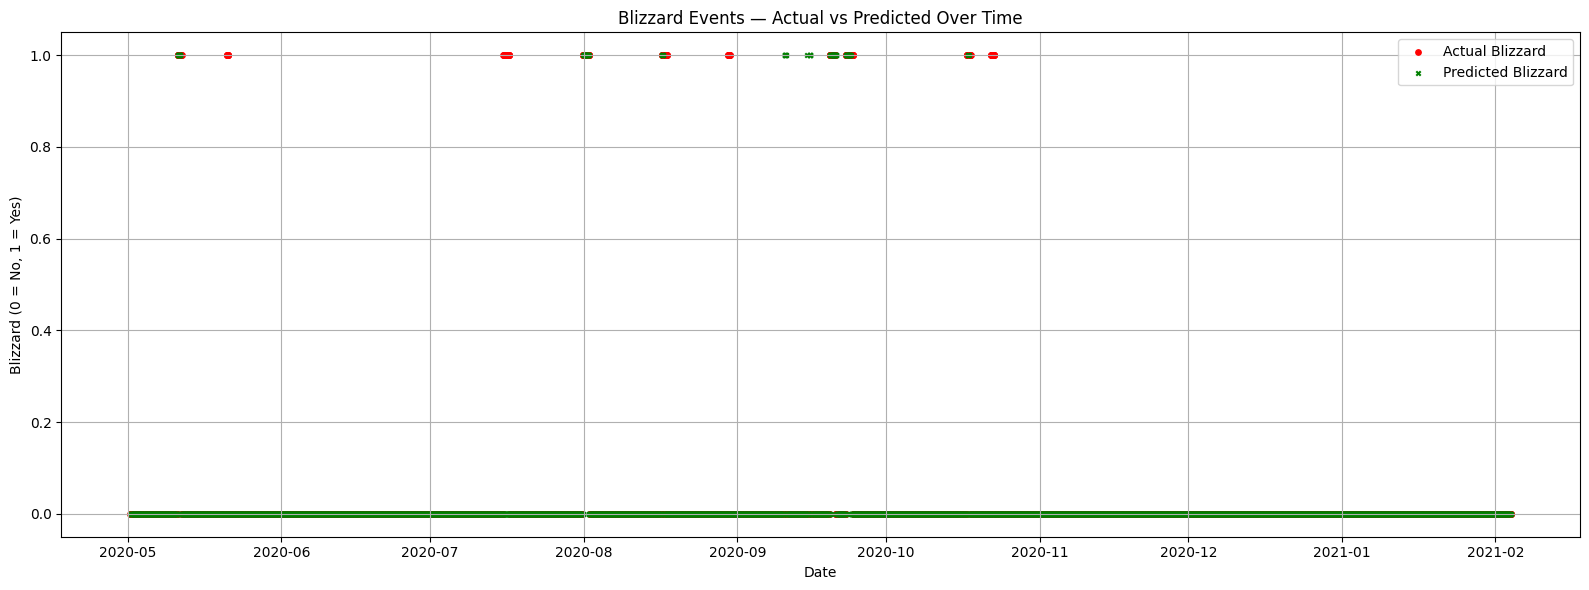

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure to align indices like before:
df_dates = df.index.to_numpy()

test_start_idx = int(val_end)
test_end_idx = len(df)
test_indices = np.arange(test_start_idx, test_end_idx)

# Adjust indices to match test_labels length
adjusted_test_indices = test_indices[:len(test_labels)]

# X-axis: Dates
test_dates = df_dates[adjusted_test_indices]

# Y-axis: Actual and Predicted
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

plt.figure(figsize=(16, 6))

# Plot Actual labels (0 or 1)
plt.scatter(test_dates, test_labels, color='red', label='Actual Blizzard', s=15, marker='o')

# Plot Predicted labels (0 or 1)
plt.scatter(test_dates, test_preds, color='green', label='Predicted Blizzard', s=10, marker='x')

# Labels and Title
plt.xlabel('Date')
plt.ylabel('Blizzard (0 = No, 1 = Yes)')
plt.title('Blizzard Events — Actual vs Predicted Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


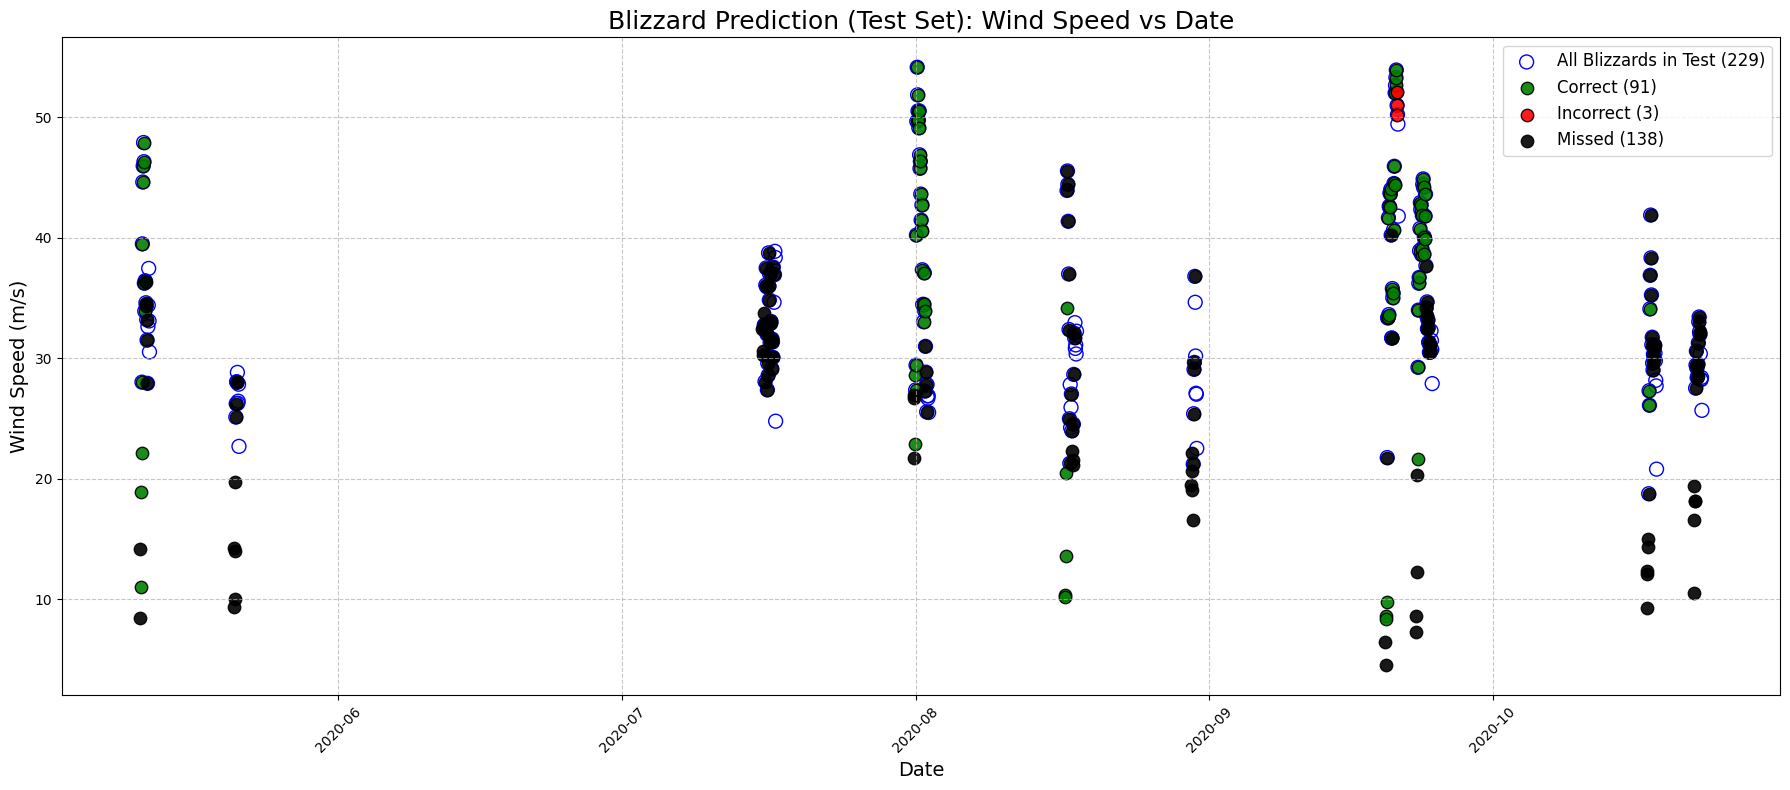

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure adjusted test indices
df_dates = df.index.to_numpy()

test_start_idx = int(val_end)
test_end_idx = len(df)
test_indices = np.arange(test_start_idx, test_end_idx)

adjusted_test_indices = test_indices[:len(test_labels)]

# Test Set data
test_dates = df_dates[adjusted_test_indices]
test_ws = df.iloc[adjusted_test_indices]['ws'].values
test_blizzard_groundtruth = df.iloc[adjusted_test_indices]['blizzard'].values

# Convert to NumPy arrays if not already
test_labels = np.array(test_labels)   # Ground truth for model input
test_preds = np.array(test_preds)     # Model predictions

# Identify:
TP_indices = (test_labels == 1) & (test_preds == 1)   # Correct: True Positives
FP_indices = (test_labels == 0) & (test_preds == 1)   # Incorrect: False Positives
FN_indices = (test_labels == 1) & (test_preds == 0)   # Missed: False Negatives

# Blizzard Ground Truth (only in Test Set)
blizzard_test_indices = (test_blizzard_groundtruth == 1)

# Plot
plt.figure(figsize=(18, 8))

# All Actual Blizzards in Test Set — Open Blue Circles
plt.scatter(test_dates[blizzard_test_indices], test_ws[blizzard_test_indices],
            facecolors='none', edgecolors='blue', s=100,
            label=f'All Blizzards in Test ({np.sum(blizzard_test_indices)})')

# Correct Predictions (TP) — Green
plt.scatter(test_dates[TP_indices], test_ws[TP_indices],
            color='green', edgecolor='black', alpha=0.9,
            label=f'Correct ({np.sum(TP_indices)})', s=80)

# Incorrect Predictions (FP) — Red
plt.scatter(test_dates[FP_indices], test_ws[FP_indices],
            color='red', edgecolor='black', alpha=0.9,
            label=f'Incorrect ({np.sum(FP_indices)})', s=80)

# Missed Predictions (FN) — Black
plt.scatter(test_dates[FN_indices], test_ws[FN_indices],
            color='black', edgecolor='black', alpha=0.9,
            label=f'Missed ({np.sum(FN_indices)})', s=80)

# Aesthetics
plt.xlabel('Date', fontsize=14)
plt.ylabel('Wind Speed (m/s)', fontsize=14)
plt.title('Blizzard Prediction (Test Set): Wind Speed vs Date', fontsize=18)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('Bleh.png',dpi = 600)
plt.show()
